In [1]:
# %cd ..
import numpy as np, matplotlib.pyplot as plt
import inputs, simuls, analysis
results = analysis.GetResults(verbose=True)

# PenEasy SPC simulation

In [2]:
pid = 'SPC'
ver = '24'
# Initialize PenEasy Input Editor
peneasy_inps = inputs.PenEasy(verbose=True)

# Initialize Simulators (identified by pid)
peneasy_sims = simuls.PenEasy(verbose=True)
peneasy_sims.activate_pid(pid, ver)

penEasy 2024 SPC activated


In [3]:
SIZE = [20]*3   
STEP = [0.4]*3  #cm
nhist = "1e6"

peneasy_inps.edit_seed(pid, 12345, 54321)
peneasy_inps.edit_source_nhist(pid, nhist)
peneasy_inps.edit_voxSize(pid, SIZE, STEP)

"penEasy/pen*.in" random seeds modified to 12345 and 54321
"penEasy/pen??_spc.in" and "penEasy/pen??_nuc.in" number of histories modified to 1e6
"penEasy/phantomN.vox" updated to point source of activity 1e6
"penEasy/pen??_spc.in" and "penEasy/pen??_nuc.in" coordinates of box center modified to (4, 4, 4)
"penEasy/phantomN.vox" voxel size modified to (0.4, 0.4, 0.4)


In [4]:
isotopes = ["C11", "F18", "Ga68"] 
MATS = [
    #material   mat_name   mat_id  density (g/cm3)
    {'lung' : ['lungICRP', 1,     0.30+00]},
    {'bone' : ['boneB100', 1,     1.45+00]}
        ]

peneasy_inps.verbose = False
for iso in isotopes:
    print(f"****SIMULATING {iso}****")
    peneasy_inps.edit_isotope(pid, iso)
    for MAT in MATS:
        material = list(MAT.keys())[0]
        print(f"Simulating {material}")
        peneasy_inps.edit_mat(pid, MAT, SIZE, STEP)
    
        res_folder = f"RESULTS/SPC/{material.capitalize()}/PenEasy20{ver}_xyz"
        peneasy_sims.simulate(pid, get_times=True, time_samples=1, output_dir=res_folder, final_file=f"{iso}.dat.original")

****SIMULATING C11****
Simulating lung
penEasy 2024 SPC real time: 121.735 +- 0.000 s
Simulating bone
penEasy 2024 SPC real time: 139.170 +- 0.000 s
****SIMULATING F18****
Simulating lung
penEasy 2024 SPC real time: 114.439 +- 0.000 s
Simulating bone
penEasy 2024 SPC real time: 129.421 +- 0.000 s
****SIMULATING Ga68****
Simulating lung
penEasy 2024 SPC real time: 138.522 +- 0.000 s
Simulating bone
penEasy 2024 SPC real time: 157.476 +- 0.000 s


In [6]:
for MAT in MATS:
    material = list(MAT.keys())[0]
    res_folder = f"RESULTS/SPC/{material.capitalize()}/PenEasy20{ver}_xyz"
    times_file = res_folder + "/" + pid + "_times.txt"
    times = np.loadtxt(times_file).astype("str")
    times[:,1], times[:,0] = times[:,0], isotopes
    np.savetxt(times_file, times, fmt='%s')
    print(f"Saved times for {material} in {times_file}")

Saved times for lung in RESULTS/SPC/Lung/PenEasy2024_xyz/SPC_times.txt
Saved times for bone in RESULTS/SPC/Bone/PenEasy2024_xyz/SPC_times.txt


# PeneloPET simulation

In [ ]:
pid = '2024'
# Initialize PeneloPET Input Editor
penelopet_inps = inputs.PeneloPET(verbose=True)

# Initialize Simulators (identified by pid)
penelopet_sims = simuls.PeneloPET(verbose=True)
penelopet_sims.activate_pid('2024')

In [ ]:
MATS = [
    #material   mat_name   mat_id  density (g/cm3)
    {'Lung' : ['lung', 1,     0.30+00]},
    {'Bone' : ['bone_B100', 1,     1.45+00]}
        ]
nhist = "1.1e6"

pid = '2024'
penelopet_inps.edit_seed(pid, 12345, 54321)

In [ ]:
isotopes = ["C11", "F18", "Ga68"] 


penelopet_inps.verbose = False
for MAT in MATS:
    material = list(MAT.keys())[0]
    print(f"****SIMULATING {material}****")
    penelopet_inps.edit_mat(pid, MAT)
    res_folder = f"RESULTS/SPC/{material}/PeneloPET2024_xyz"
    for iso in isotopes:
        print(f"Simulating {iso}")
        penelopet_inps.edit_isotope(pid, iso)
        if iso == "I124":
            penelopet_inps.edit_source_activity(pid, str(float(nhist)*5))
        else:
            penelopet_inps.edit_source_activity(pid, nhist)
        penelopet_sims.simulate(pid, get_times=True, time_samples=1, output_dir=res_folder, final_file=f"{iso}")

In [ ]:
material = 'Lung'
res_folder = f"RESULTS/SPC/{material}/PeneloPET2024_xyz"
times_file = res_folder + "/" + pid + "_times.txt"
times = np.loadtxt(times_file).astype("str")
times[:,1], times[:,0] = times[:,0], isotopes
np.savetxt(times_file, times, fmt='%s')

# vGATE 9.x simulation

In [ ]:
pid = '9'
# Initialize GATE Input Editor
gate_inps = inputs.GATE(verbose=True)

# Initialize Simulators (identified by pid)
gate_sims = simuls.GATE(verbose=True)
gate_sims.activate_pid(pid, output_format='dat')

In [ ]:
nhist = "1e6"

gate_inps.edit_seed(pid)
gate_inps.edit_source_nhist(pid, nhist)

In [ ]:
isotopes = ["C11", "F18", "Ga68"] 
MATS = {
    # SIZE     STEP (cm)   material   mat_name   mat_id  density (g/cm3)
    ((20,)*3, (0.3,)*3 ) : {'lung' : ['LungICRP', 2,     0.30+00]},
    ((20,)*3, (0.07,)*3) : {'bone' : ['BoneB100', 12,    1.45+00]}
        }

gate_inps.verbose = False
for STEPnSIZE, MAT in MATS.items():
    material = list(MAT.keys())[0]
    # if material == 'lung':
    #     continue
    print(f"****SIMULATING {material}****")

    SIZE, STEP = STEPnSIZE
    gate_inps.edit_voxSize(pid, SIZE, STEP)
    gate_inps.edit_mat(pid, MAT, SIZE, STEP)

    res_folder = f"RESULTS/SPC/{material.capitalize()}/GATE93_xyz"
    for iso in isotopes:
        print(f"--Simulating {iso}")
        gate_inps.edit_isotope(pid, iso)
        gate_sims.simulate(pid, get_times=True, time_samples=1, output_dir=res_folder, final_file=f"{iso}")


In [ ]:
import numpy as np

for STEPnSIZE, MAT in MATS.items():
    material = list(MAT.keys())[0]
    if material == 'lung':
        continue
    res_folder = f"RESULTS/SPC/{material.capitalize()}/GATE93_xyz"
    times_file = res_folder + "/" + pid + "_times.txt"
    times = np.loadtxt(times_file).astype("str")
    times[:,1], times[:,0] = times[:,0], isotopes
    np.savetxt(times_file, times, fmt='%s')

# GATE 7.0beta simulation

In [ ]:
pid = '7'
# Initialize GATE Input Editor
gate_inps = inputs.GATE(verbose=True)

# Initialize Simulators (identified by pid)
gate_sims = simuls.GATE(verbose=True)
gate_sims.activate_pid(pid, output_format='dat')

In [ ]:
isotopes = ["C11", "F18"] 
MATS = [
    # material   mat_name   mat_id  density (g/cm3)
    {'lung' : ['LungICRP', 2,     0.30+00]},
    {'bone' : ['BoneB100', 12,    1.45+00]},
]
nhist = "1e6"

gate_inps.edit_seed(pid)
gate_inps.edit_source_nhist(pid, nhist)

In [ ]:
gate_inps.verbose = False
for MAT in MATS:
    material = list(MAT.keys())[0]
    print(f"****SIMULATING {material}****")

    SIZE, STEP = (20,)*3, (0.4,)*3
    gate_inps.edit_mat(pid, MAT, SIZE, STEP)

    res_folder = f"RESULTS/SPC/{material.capitalize()}/GATE7_xyz"
    for iso in isotopes:
        print(f"--Simulating {iso}")
        gate_inps.edit_isotope(pid, iso)
        gate_sims.simulate(pid, get_times=True, time_samples=1, output_dir=res_folder, final_file=f"{iso}")


In [ ]:
print(MATS.items())

In [ ]:
material = 'Bone'
res_folder = f"RESULTS/SPC/{material}/GATE7_xyz"
times_file = res_folder + "/" + pid + "_times.txt"
times = np.loadtxt(times_file).astype("str")
times[:,1], times[:,0] = times[:,0], isotopes
np.savetxt(times_file, times, fmt='%s')

# Results analysis

In [8]:
program_folder = "PenEasy2024_xyz"
mat = "Bone"
folder = f"RESULTS/SPC/{mat}/{program_folder}"
trim = int(1e6)

if mat == "Bone":
    rthresh = {"C11" : 4, "F18" : 2, "Ga68" : 8}
elif mat== "Lung":
    rthresh = {"C11" : 15, "F18" : 8, "Ga68" : 30}

for iso in rthresh.keys():
    if program_folder == "GATE7_xyz" and iso not in ["C11", "O15", "F18"]:
        continue
    print(f"Filtering {iso}")
    threshold = rthresh[iso] #mm
    analysis.filter_rmax(f"{folder}/{iso}.dat.original", f"{folder}/{iso}.dat", threshold=threshold, trim=trim, fmt='%.6f')

Filtering C11
Filtered 'RESULTS/SPC/Bone/PenEasy2024_xyz/C11.dat.original' to 'RESULTS/SPC/Bone/PenEasy2024_xyz/C11.dat': 0 points removed
Filtering F18
Filtered 'RESULTS/SPC/Bone/PenEasy2024_xyz/F18.dat.original' to 'RESULTS/SPC/Bone/PenEasy2024_xyz/F18.dat': 0 points removed
Filtering Ga68
Filtered 'RESULTS/SPC/Bone/PenEasy2024_xyz/Ga68.dat.original' to 'RESULTS/SPC/Bone/PenEasy2024_xyz/Ga68.dat': 0 points removed


In [9]:
histo_bins = 401
histo_step = .005 #cm
isotopes = ["C11", "F18", "Ga68"] 
mats = ["Lung", "Bone"]
pfolders = {
    "PHITS 3.3":"PHITS_xyz", 
    "PenEasy 2020":"PenEasy2020_xyz",
    "PenEasy 2024":"PenEasy2024_xyz",
    "PeneloPET 2024":"PeneloPET2024_xyz", 
    "GATE 7.0":"GATE7_xyz",
    "GATE 9.2":"GATE92_xyz", 
    "GATE 9.3":"GATE93_xyz",
}

labels_iso = {mat:{iso:[] for iso in isotopes} for mat in mats}
labels_prg = {mat:{p:[] for p in pfolders.keys()} for mat in mats}

results.active_results.clear()
for mat in mats:
    for iso in isotopes:
        for pname, pfolder in pfolders.items():
            if pfolder == "GATE7_xyz" and iso not in ["C11", "F18"]: continue
            # file with results
            rf = f"RESULTS/SPC/{mat}/{pfolder}/{iso}.dat"
            # result label
            rl = f"{pname} {iso} {mat}"
            
            # load results
            results.load(rl, rf, [histo_bins]*3, [histo_step]*3)

            # store labels
            labels_iso[mat][iso].append(rl)
            labels_prg[mat][pname].append(rl)

PHITS 3.3 C11 Lung loaded
PenEasy 2020 C11 Lung loaded
PenEasy 2024 C11 Lung loaded
PeneloPET 2024 C11 Lung loaded
GATE 7.0 C11 Lung loaded
GATE 9.2 C11 Lung loaded
GATE 9.3 C11 Lung loaded
PHITS 3.3 F18 Lung loaded
PenEasy 2020 F18 Lung loaded
PenEasy 2024 F18 Lung loaded
PeneloPET 2024 F18 Lung loaded
GATE 7.0 F18 Lung loaded
GATE 9.2 F18 Lung loaded
GATE 9.3 F18 Lung loaded
PHITS 3.3 Ga68 Lung loaded
PenEasy 2020 Ga68 Lung loaded
PenEasy 2024 Ga68 Lung loaded
PeneloPET 2024 Ga68 Lung loaded
GATE 9.2 Ga68 Lung loaded
GATE 9.3 Ga68 Lung loaded
PHITS 3.3 C11 Bone loaded
PenEasy 2020 C11 Bone loaded
PenEasy 2024 C11 Bone loaded
PeneloPET 2024 C11 Bone loaded
GATE 7.0 C11 Bone loaded
GATE 9.2 C11 Bone loaded
GATE 9.3 C11 Bone loaded
PHITS 3.3 F18 Bone loaded
PenEasy 2020 F18 Bone loaded
PenEasy 2024 F18 Bone loaded
PeneloPET 2024 F18 Bone loaded
GATE 7.0 F18 Bone loaded
GATE 9.2 F18 Bone loaded
GATE 9.3 F18 Bone loaded
PHITS 3.3 Ga68 Bone loaded
PenEasy 2020 Ga68 Bone loaded
PenEasy 2024

In [10]:
results.data_analysis()

Size of annihilations sample:
     PHITS 3.3 C11 Lung                      	    988257
     PenEasy 2020 C11 Lung                   	    999853
     PenEasy 2024 C11 Lung                   	    999962
     PeneloPET 2024 C11 Lung                 	   1000000
     GATE 7.0 C11 Lung                       	   1000000
     GATE 9.2 C11 Lung                       	   1000000
     GATE 9.3 C11 Lung                       	   1000000
     PHITS 3.3 F18 Lung                      	   1000000
     PenEasy 2020 F18 Lung                   	    999522
     PenEasy 2024 F18 Lung                   	    999607
     PeneloPET 2024 F18 Lung                 	   1000000
     GATE 7.0 F18 Lung                       	   1000000
     GATE 9.2 F18 Lung                       	   1000000
     GATE 9.3 F18 Lung                       	   1000000
     PHITS 3.3 Ga68 Lung                     	   1000000
     PenEasy 2020 Ga68 Lung                  	   1000000
     PenEasy 2024 Ga68 Lung                  	    998622
 

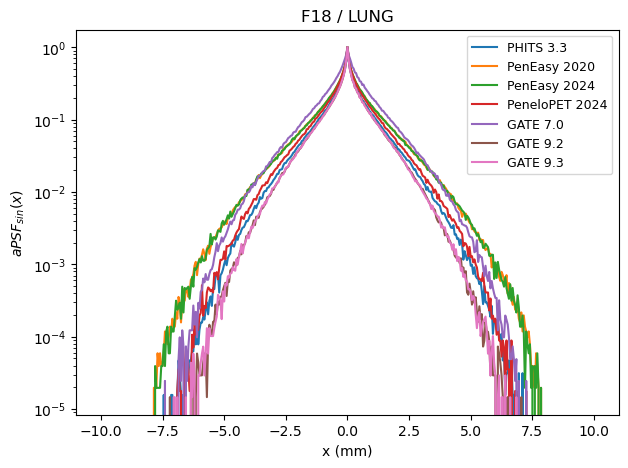

In [11]:
mat = "Lung"
iso = "F18"
l = labels_iso[mat][iso]
sl = list(labels_prg[mat].keys())
if iso not in ["C11", "F18"] and "GATE 7.0" in sl:
    sl.remove("GATE 7.0")
sl = dict(zip(l, sl))
plt.figure(figsize=(7,5))
results.plot_aPSFx(sin=True, log_scale=True, labels=l, sublabels=sl, title=f"{iso} / {mat.upper()}")
plt.show()

In [ ]:
mat = "Bone"
iso = "C11"
l = labels_iso[mat][iso]
sl = list(labels_prg[mat].keys())
if iso not in ["C11", "F18"] and "GATE 7.0" in sl:
    sl.remove("GATE 7.0")
sl = dict(zip(l, sl))
plt.figure(figsize=(7,5))
results.plot_aPSFx(sin=True, lim=2.5, log_scale=True, labels=l, sublabels=sl, title=f"{iso} / {mat.upper()}")
plt.show()

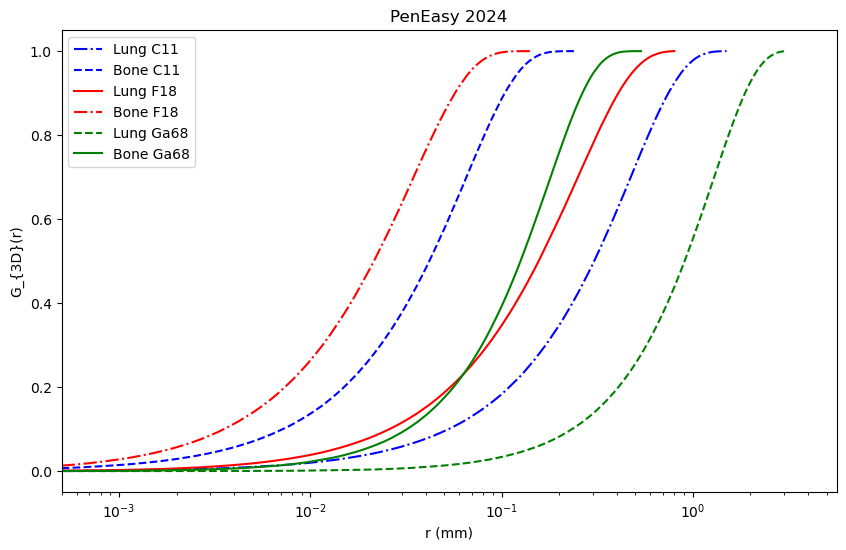

In [14]:
p = "PenEasy 2024"

plt.figure(figsize=(10, 6))

plt.title(f"{p}")
plt.xlabel("r (mm)")
plt.ylabel(r"G_{3D}(r)")
for iso in isotopes if p!="GATE 7.0" else ["C11", "F18"]:
    c = next(color_iso)
    for mat in mats:
        l = f"{p} {iso} {mat}"
        res = results.active_results[l]
        x = res.rsort
        x = x
        y = res.G3D_nohist
        plt.plot(x, y, c+next(style_mat), label=f"{mat} {iso}")
plt.xscale('log')
plt.xlim(5e-4, None)
plt.legend()


plt.show()

In [ ]:
mat = "Bone"
iso = "F18"
l = labels_iso[mat][iso]
sl = list(labels_prg[mat].keys())
if iso not in ["C11", "F18"] and "GATE 7.0" in sl:
    sl.remove("GATE 7.0")
sl = dict(zip(l, sl))
results.plot_G3D_nohist(labels=l, sublabels=sl, title=f"{iso} / {mat.upper()}")

In [ ]:
mat = "Bone"
plt.figure(figsize=(20,12))
kmax = len(labels_prg[mat])
max_cols = 3
max_rows = int(np.ceil(kmax/max_cols))
for k, p in enumerate(labels_prg[mat].keys()):
    l = labels_prg[mat][p]
    sl = dict(zip(l, isotopes if p!="GATE 7.0" else ["C11", "F18"]))
    plt.subplot(max_rows, max_cols, k+1)
    results.plot_G3D_nohist(labels=l, sublabels=sl, title=f"{p}", legend_size=12)
plt.show()

# PR proportionality

In [ ]:
from itertools import cycle
style_mat = cycle(["-","-.","--"])
color_iso = cycle(["r","g","b"])
 
kmax = len(labels_prg[mat])
max_cols = 3
max_rows = int(np.ceil(kmax/max_cols))

plt.figure(figsize=(20, 5*max_rows))
for k, p in enumerate(pfolders.keys()):
    plt.subplot(max_rows, max_cols, k+1)
    plt.title(f"{p}")
    plt.xlabel("r (mm)")
    plt.ylabel(r"G_{3D}(r)")
    for iso in isotopes if p!="GATE 7.0" else ["C11", "F18"]:
        c = next(color_iso)
        for mat in mats:
            l = f"{p} {iso} {mat}"
            res = results.active_results[l]
            x = res.rsort
            x = x
            y = res.G3D_nohist
            plt.plot(x, y, c+next(style_mat), label=f"{mat} {iso}")
    plt.xscale('log')
    plt.xlim(5e-4, None)
    plt.legend()


plt.show()

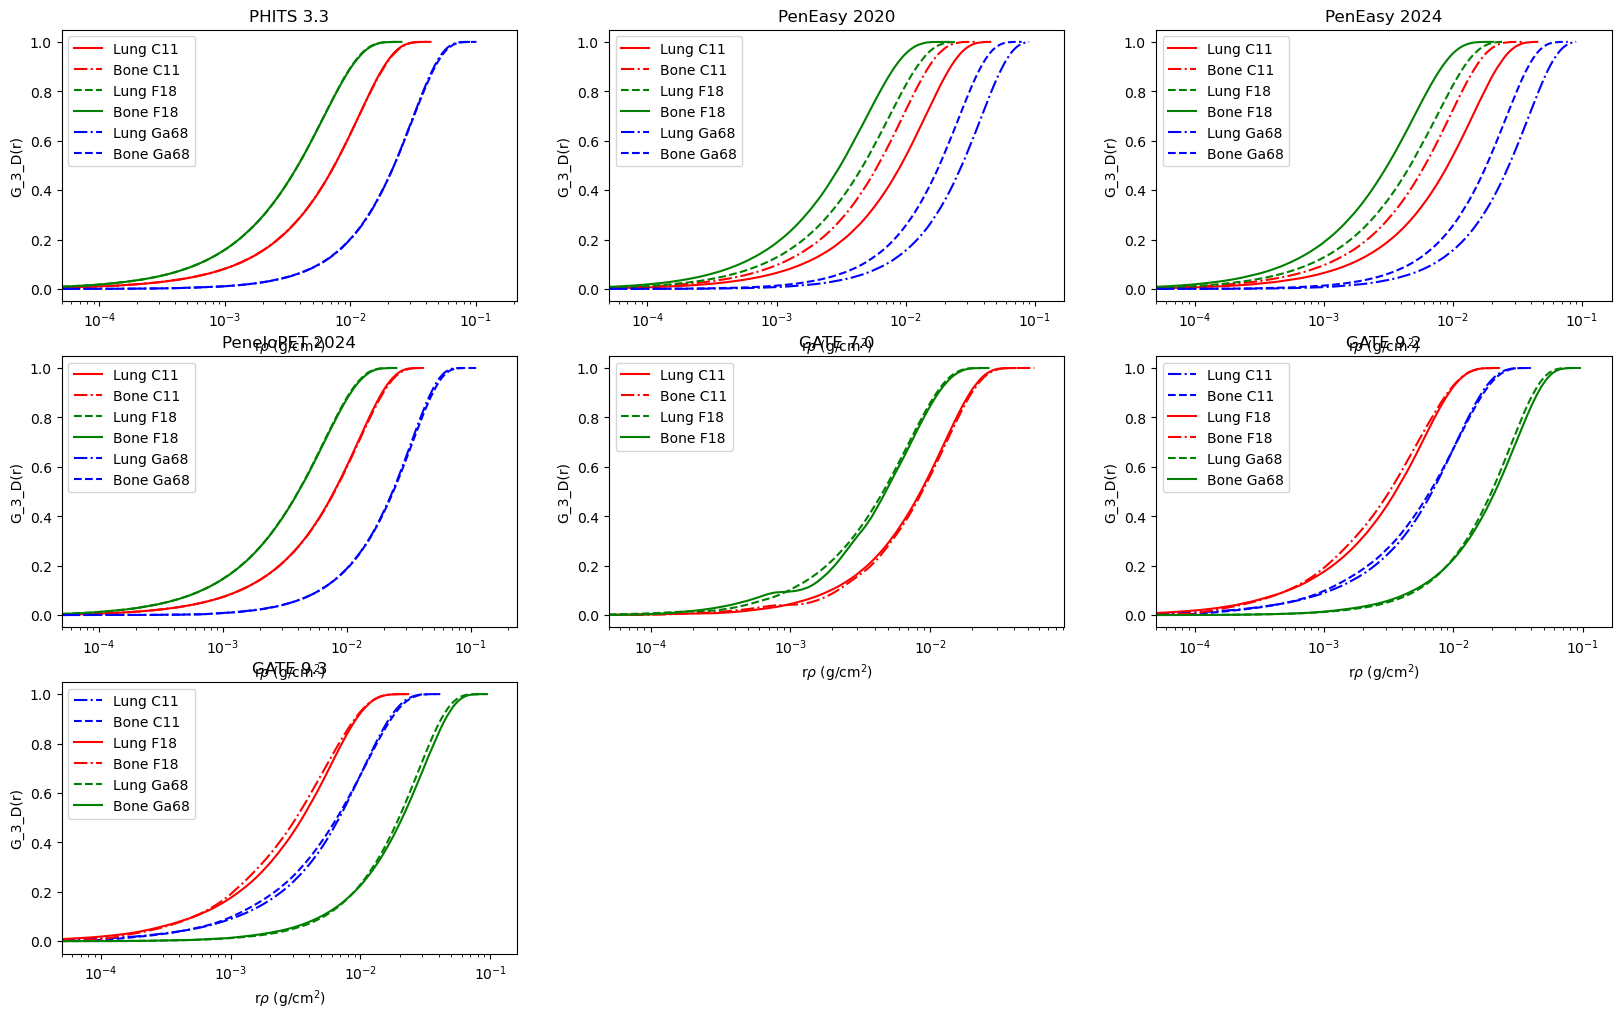

In [ ]:
from itertools import cycle
style_mat = cycle(["-","-.","--"])
color_iso = cycle(["r","g","b"])

dens = { # g/cm3
    "Lung":0.3000,#*7.143064,
    "Water":1.000,#*5.44053,
    "Bone":1.45,#*8.732794,
        }
 
kmax = len(labels_prg[mat])
max_cols = 3
max_rows = int(np.ceil(kmax/max_cols))

plt.figure(figsize=(20, 5*max_rows))
for k, p in enumerate(pfolders.keys()):
    plt.subplot(max_rows, max_cols, k+1)
    plt.title(f"{p}")
    plt.xlabel(r"r$\rho$ (g/cm$^2$)")
    plt.ylabel("G_3_D(r)")
    for iso in isotopes if p!="GATE 7.0" else ["C11", "F18"]:
        c = next(color_iso)
        for mat in mats:
            l = f"{p} {iso} {mat}"
            res = results.active_results[l]
            x = res.rsort
            x = x/10*dens[mat]
            y = res.G3D_nohist
            plt.plot(x, y, c+next(style_mat), label=f"{mat} {iso}")
    plt.xscale('log')
    plt.xlim(5e-5, None)
    plt.legend()


plt.show()